In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import time
import os

In [3]:
working_dir = '/content/drive/My Drive/UT_Austin/Diffusion_Models_Testing/generalization_in_diffusion_models_backup'
os.chdir(working_dir)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]

class ScoreNetGMM(nn.Module):
    def __init__(self, data_dim=2, hidden_dims=[16, 32, 64], embed_dim=128):
        super().__init__()

        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Store dimensions
        self.data_dim = data_dim
        self.hidden_dims = hidden_dims
        self.embed_dim = embed_dim

        # Encoding layers
        self.encoder = nn.ModuleList([
            nn.Linear(data_dim, hidden_dims[0]),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.Linear(hidden_dims[1], hidden_dims[2])
        ])

        # Time projections for encoding
        self.time_proj = nn.ModuleList([
            nn.Linear(embed_dim, dim) for dim in hidden_dims
        ])

        # Decoding layers
        self.decoder = nn.ModuleList([
            nn.Linear(hidden_dims[2], hidden_dims[1]),
            nn.Linear(hidden_dims[1] * 2, hidden_dims[0]),  # *2 for skip connection
            nn.Linear(hidden_dims[0] * 2, data_dim)  # *2 for skip connection
        ])

        # Group norms
        self.gnorms = nn.ModuleList([
            nn.GroupNorm(4, num_channels=hidden_dims[0]),
            nn.GroupNorm(4, num_channels=hidden_dims[1]),
            nn.GroupNorm(4, num_channels=hidden_dims[2])
        ])

        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = None


    def forward(self, x, t):

        # Get time embedding
        embed = self.act(self.embed(t))

        # Reshape input
        B, C, H, W = x.shape
        x = x.reshape(B, -1, W)  # [B, C*H, W]

        # Store skip connections
        hs = []
        h = x

        # Encoding
        for i, (layer, gnorm, t_proj) in enumerate(zip(self.encoder, self.gnorms, self.time_proj)):
            h = layer(h)
            time_emb = t_proj(embed).unsqueeze(1)
            h = h + time_emb
            h = gnorm(h.transpose(1, 2)).transpose(1, 2)
            h = self.act(h)
            if i < len(self.encoder) - 1:
                hs.append(h)

        # Decoding
        for i, layer in enumerate(self.decoder):
            if i > 0:  # Apply skip connections from layer 2 onwards
                h = torch.cat([h, hs[-i]], dim=2)
            h = layer(h)
            if i < len(self.decoder) - 1:  # No activation on final layer
                h = self.act(h)

        # Reshape back
        score = h.reshape(B, C, H, W)

        # Normalize output
        if self.marginal_prob_std is not None:
            score = score / self.marginal_prob_std(t)[:, None, None, None]

        return score

In [4]:
class GaussianMixture:
  def __init__(self, mus, covs, weights):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch.
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.covs = covs
    self.precs = [np.linalg.inv(cov) for cov in covs]
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(multivariate_normal(mus[i], covs[i]))
    self.dim = len(mus[0])

  def add_component(self, mu, cov, weight=1):
    self.mus.append(mu)
    self.covs.append(cov)
    self.precs.append(np.linalg.inv(cov))
    self.RVs.append(multivariate_normal(mu, cov))
    self.weights.append(weight)
    self.norm_weights = self.weights / self.weights.sum()
    self.n_component += 1

  def pdf_decompose(self, x):
    """
      probability density (PDF) at $x$.
    """
    component_pdf = []
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
        component_pdf.append(pdf)
    component_pdf = np.array(component_pdf)
    return prob, component_pdf

  def pdf(self, x):
    """
      probability density (PDF) at $x$.
    """
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
    # component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    # prob = np.dot(component_pdf, self.norm_weights)
    return prob

  def score(self, x):
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    scores = np.zeros_like(x)
    for i in range(self.n_component):
        # Ensure mean is broadcast correctly
        mean_expanded = np.broadcast_to(self.mus[i], x.shape)
        gradvec = - (x - mean_expanded) @ self.precs[i]
        scores += participance[:, i:i+1] * gradvec

    return scores

  def score_decompose(self, x):
    """
    Compute the grad to each branch for the score $\nabla_x \log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    gradvec_list = []
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      gradvec_list.append(gradvec)
      # scores += participance[:, i:i+1] * gradvec

    return gradvec_list, participance

  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights.
      Choose sample between the branches according to the indices.
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.rvs(N) for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples

In [6]:
working_dir = '/content/drive/MyDrive/UT_Austin/Diffusion_Models_Testing/memorization_generalization_in_diffusion_models/datasets'
os.chdir(working_dir)
gmm_params = torch.load('gmm_params_reference.pt')

<ipython-input-6-51afb0b8833e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gmm_params = torch.load('gmm_params_reference.pt')


In [7]:
def prepare_points_for_score_net(points, device):
    B = points.shape[0]
    return points.view(B, 1, 1, -1).to(device)

def get_score_from_model(model, points, device):
    points_input = prepare_points_for_score_net(points, device)
    # Use t=0 for final score
    t = torch.zeros(points_input.shape[0], device=device)

    with torch.no_grad():
        score = model(points_input, t)
    return score.view(points.shape)

In [8]:
def categorize_samples_by_distance(points, centers, thresholds=[1.0, 2.0]):
    distances = torch.stack([
        torch.norm(points - torch.tensor(center, device=points.device), dim=1)
        for center in centers
    ])
    min_distances = distances.min(dim=0).values

    close_mask = min_distances <= thresholds[0]
    medium_mask = (min_distances > thresholds[0]) & (min_distances <= thresholds[1])
    far_mask = min_distances > thresholds[1]

    return close_mask, medium_mask, far_mask

In [26]:
def plot_score_fields(model, gmm, device, plot_size=50):
    model.eval()

    x = np.linspace(-4, 4, plot_size)
    y = np.linspace(-4, 4, plot_size)
    X, Y = np.meshgrid(x, y)
    points = np.stack([X.flatten(), Y.flatten()], axis=1)
    points_tensor = torch.tensor(points, device=device, dtype=torch.float32)

    true_scores = torch.tensor(gmm.score(points), device=device)

    close_mask, medium_mask, far_mask = categorize_samples_by_distance(points_tensor, gmm.mus)

    model_scores = get_score_from_model(model, points_tensor, device)

    #points_tensor = torch.tensor(points, device=device, dtype=torch.float32)
    #model_scores = get_score_from_model(model, points_tensor, device)
    #true_scores = torch.tensor(gmm.score(points), device=device)

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    ax = axes[0,0]
    Z = gmm.pdf(points).reshape(plot_size, plot_size)
    contour = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(contour, ax=ax)
    ax.set_title('GMM Density')

    ax = axes[0,1]
    quiver_true = ax.quiver(points[:, 0], points[:, 1],
                           true_scores[:, 0], true_scores[:, 1],
                           alpha=0.5)
    ax.set_title('GMM True Score Field')

    ax = axes[0,2]
    quiver_derived = ax.quiver(points[:, 0], points[:, 1],
                          model_scores.cpu()[:, 0], model_scores.cpu()[:, 1],
                          alpha=0.5)
    ax.set_title('Model Score Field')

    cos_sim = torch.nn.functional.cosine_similarity(model_scores, true_scores).mean()
    l2_diffs = torch.norm(model_scores - true_scores, dim=1)
    avg_l2 = l2_diffs.mean()
    ax.text(0.05, 0.95, f'L2: {avg_l2:.2f}\nCos Sim: {cos_sim:.2f}',
            transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

    ax = axes[1,0]
    colors = np.empty(len(points), dtype=object)
    colors[close_mask.cpu()] = 'tab:red'
    colors[medium_mask.cpu()] = 'tab:green'
    colors[far_mask.cpu()] = 'tab:purple'

    quiver = ax.quiver(points[:, 0], points[:, 1],
                       model_scores.cpu()[:, 0], model_scores.cpu()[:, 1],
                       color=colors, alpha=0.5)

    l2_close = l2_diffs[close_mask].mean()
    l2_medium = l2_diffs[medium_mask].mean()
    l2_far = l2_diffs[far_mask].mean()

    legend_elements = [
        plt.Line2D([0], [0], color='tab:red', label=f'Close - L2 {l2_close:.2f}'),
        plt.Line2D([0], [0], color='tab:green', label=f'Mid - L2 {l2_medium:.2f}'),
        plt.Line2D([0], [0], color='tab:purple', label=f'Far - L2 {l2_far:.2f}')
    ]
    ax.legend(handles=legend_elements)
    ax.set_title('Model Score Field by Distance Group')

    ax = axes[1,1]
    distances = torch.stack([
        torch.norm(points_tensor - torch.tensor(mu, device=device), dim=1)
        for mu in gmm.mus
    ]).min(dim=0).values.cpu()

    for mask, color, label in zip([close_mask, medium_mask, far_mask],
                                 ['tab:red', 'tab:green', 'tab:purple'],
                                 ['Close', 'Mid', 'Far']):
        mask_cpu = mask.cpu()
        ax.scatter(distances[mask_cpu], l2_diffs[mask_cpu],
                  c=color, alpha=0.5, label=label)

    ax.set_title('Score L2 Error vs Distance to Center')
    ax.set_xlabel('Distance to Nearest Center')
    ax.set_ylabel('L2 Error')
    ax.legend()

    ax = axes[1,2]

# Generate trajectories using the same function as in plot_trajectories
    def generate_trajectories(points, score_fn, n_steps=1000, step_size=0.01):
        trajectories = [points.copy()]
        current_points = points.copy()

        for _ in range(n_steps):
            score = score_fn(current_points)
            current_points = current_points + step_size * score
            trajectories.append(current_points.copy())

        return np.stack(trajectories)

# Generate model trajectories
    points_np = points_tensor.cpu().numpy()
    model_trajectories = generate_trajectories(points_np,
        lambda pts: get_score_from_model(
            model,
            torch.tensor(pts, device=device, dtype=torch.float32),
            device
        ).cpu().numpy()
    )

# Calculate L2 distances to centers during trajectory
    l2_center_close = []
    l2_center_medium = []
    l2_center_far = []

    for step_points in model_trajectories:
    # Convert to tensor for distance calculation
        points_t = torch.tensor(step_points, device=device)
        center_dists = torch.stack([
            torch.norm(points_t - torch.tensor(mu, device=device), dim=1)
            for mu in gmm.mus
        ])
        min_dists = center_dists.min(dim=0).values

        l2_center_close.append(min_dists[close_mask].mean().item())
        l2_center_medium.append(min_dists[medium_mask].mean().item())
        l2_center_far.append(min_dists[far_mask].mean().item())

# Plot distances
    steps = np.arange(len(l2_center_close))
    ax.plot(steps, l2_center_close, '-', label='Close', color='tab:red')
    ax.plot(steps, l2_center_medium, '-', label='Mid', color='tab:green')
    ax.plot(steps, l2_center_far, '-', label='Far', color='tab:purple')
    ax.set_title('L2 Distances to Centers During Trajectories')
    ax.set_xlabel('Step')
    ax.set_ylabel('Average L2 Distance')
    ax.legend()
    ax.grid(True)

    for ax in axes[:2,:1].flat:
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)

    plt.tight_layout()
    return fig

In [27]:
def plot_trajectories(model, gmm, device, plot_size=50, n_steps=1000, step_size=0.01):
    model.eval()

    x = np.linspace(-4, 4, plot_size)
    y = np.linspace(-4, 4, plot_size)
    X, Y = np.meshgrid(x, y)
    points = np.stack([X.flatten(), Y.flatten()], axis=1)
    points_tensor = torch.tensor(points, device=device, dtype=torch.float32)

    close_mask, medium_mask, far_mask = categorize_samples_by_distance(points_tensor, gmm.mus)

    def generate_trajectories(points, score_fn, n_steps=n_steps, step_size=step_size):
        trajectories = [points.copy()]
        current_points = points.copy()

        for _ in range(n_steps):
            score = score_fn(current_points)
            current_points = current_points + step_size * score
            trajectories.append(current_points.copy())

        return np.stack(trajectories)

    gmm_trajectories = generate_trajectories(points, gmm.score)

    def model_score_fn(pts):
        pts_tensor = torch.tensor(pts, device=device, dtype=torch.float32)
        scores = get_score_from_model(model, pts_tensor, device)
        return scores.cpu().numpy()

    model_trajectories = generate_trajectories(points, model_score_fn)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    centers = np.array(gmm.mus)
    step = 4

    for ax, trajectories, title in zip([ax1, ax2],
                                     [gmm_trajectories, model_trajectories],
                                     ['GMM True Score Trajectories', 'Model Score Trajectories']):
        ax.set_title(title)

        for idx in range(0, len(points), step):
            if close_mask[idx]:
                color = 'tab:red'
            elif medium_mask[idx]:
                color = 'tab:green'
            else:
                color = 'tab:purple'

            trajectory = trajectories[:, idx, :]
            ax.plot(trajectory[:, 0], trajectory[:, 1], '-',
                    color=color, alpha=0.3, linewidth=1)

        ax.scatter(centers[:, 0], centers[:, 1],
                  alpha=1.0, color='orange', marker='*', s=100)
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)

    legend_elements = [
        plt.Line2D([0], [0], color='tab:red', label='Close'),
        plt.Line2D([0], [0], color='tab:green', label='Mid'),
        plt.Line2D([0], [0], color='tab:purple', label='Far'),
        plt.Line2D([0], [0], color='orange', marker='*',
                  label='Centers', markersize=10, linestyle='None')
    ]
    ax1.legend(handles=legend_elements)
    ax2.legend(handles=legend_elements)

    plt.tight_layout()
    return fig

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mus = gmm_params['2d']['mus']
covs = gmm_params['2d']['covs']
weights = gmm_params['2d']['weights']

mus = [np.array(mu) for mu in mus]
covs = [np.array(cov) for cov in covs]
weights = np.array(weights)
model_path = '/content/drive/MyDrive/UT_Austin/Diffusion_Models_Testing/memorization_generalization_in_diffusion_models/score_models/gmm_score_model/gmm_new_2d/ckpt_10.pth'
#model_noise_type = 'gaussian'

<ipython-input-29-2cb582fb95ec>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


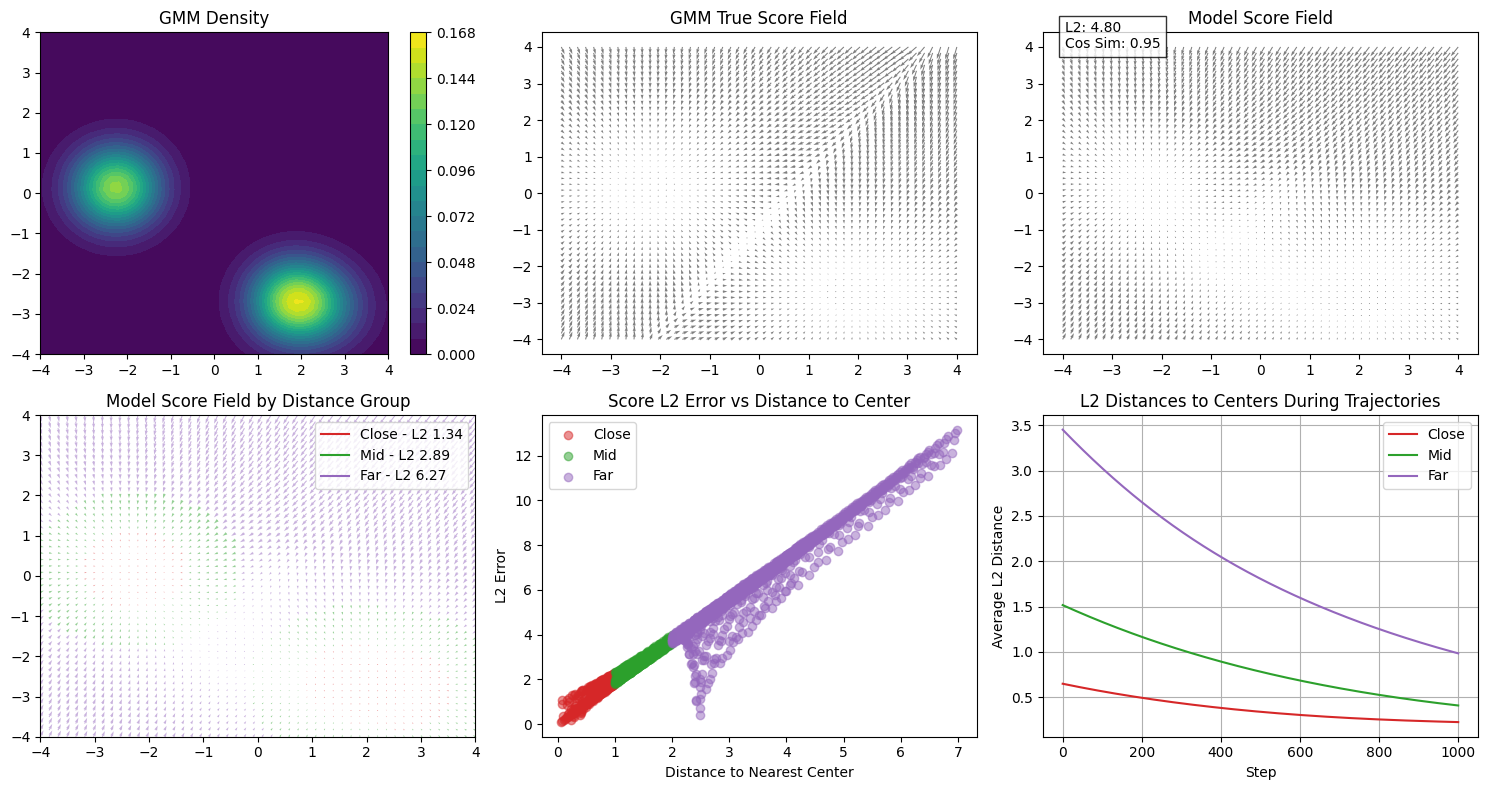

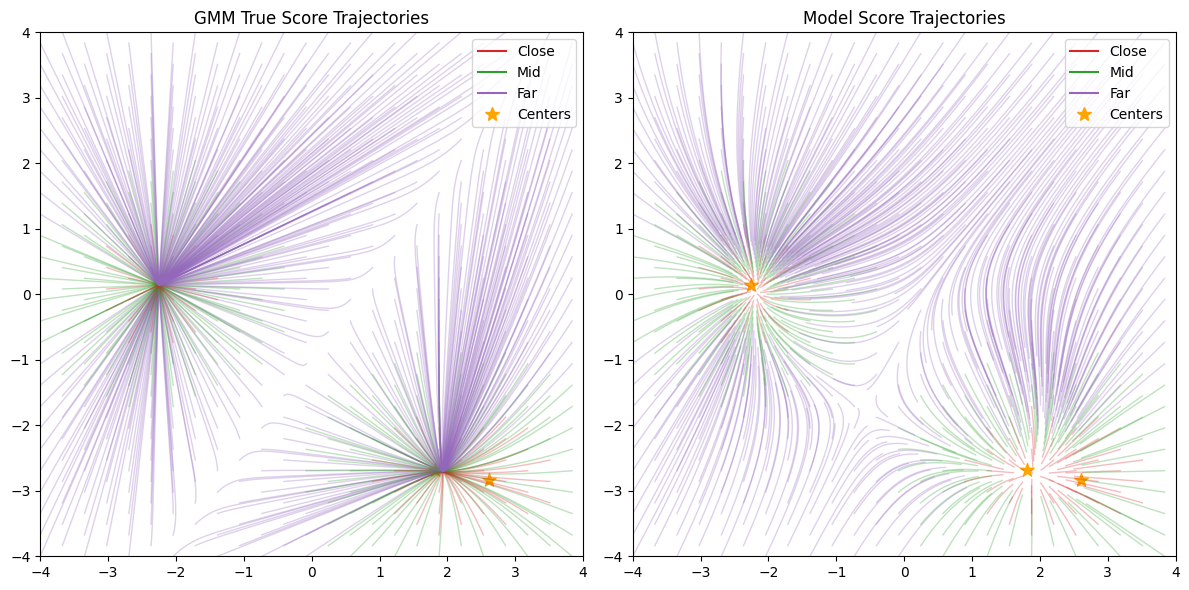

In [29]:
gmm = GaussianMixture(mus, covs, weights)

model = ScoreNetGMM(
    data_dim=2,
    hidden_dims=[128, 256, 512],
    embed_dim=256
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))

score_fig = plot_score_fields(model, gmm, device)
trajectory_fig = plot_trajectories(model, gmm, device)

plt.show()

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mus = gmm_params['2d_sharp']['mus']
covs = gmm_params['2d_sharp']['covs']
weights = gmm_params['2d_sharp']['weights']

mus = [np.array(mu) for mu in mus]
covs = [np.array(cov) for cov in covs]
weights = np.array(weights)
model_path = '/content/drive/MyDrive/UT_Austin/Diffusion_Models_Testing/memorization_generalization_in_diffusion_models/score_models/gmm_score_model/gmm_new_2d/very_sharp/ckpt_10.pth'
#model_noise_type = 'gaussian'

<ipython-input-33-2cb582fb95ec>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


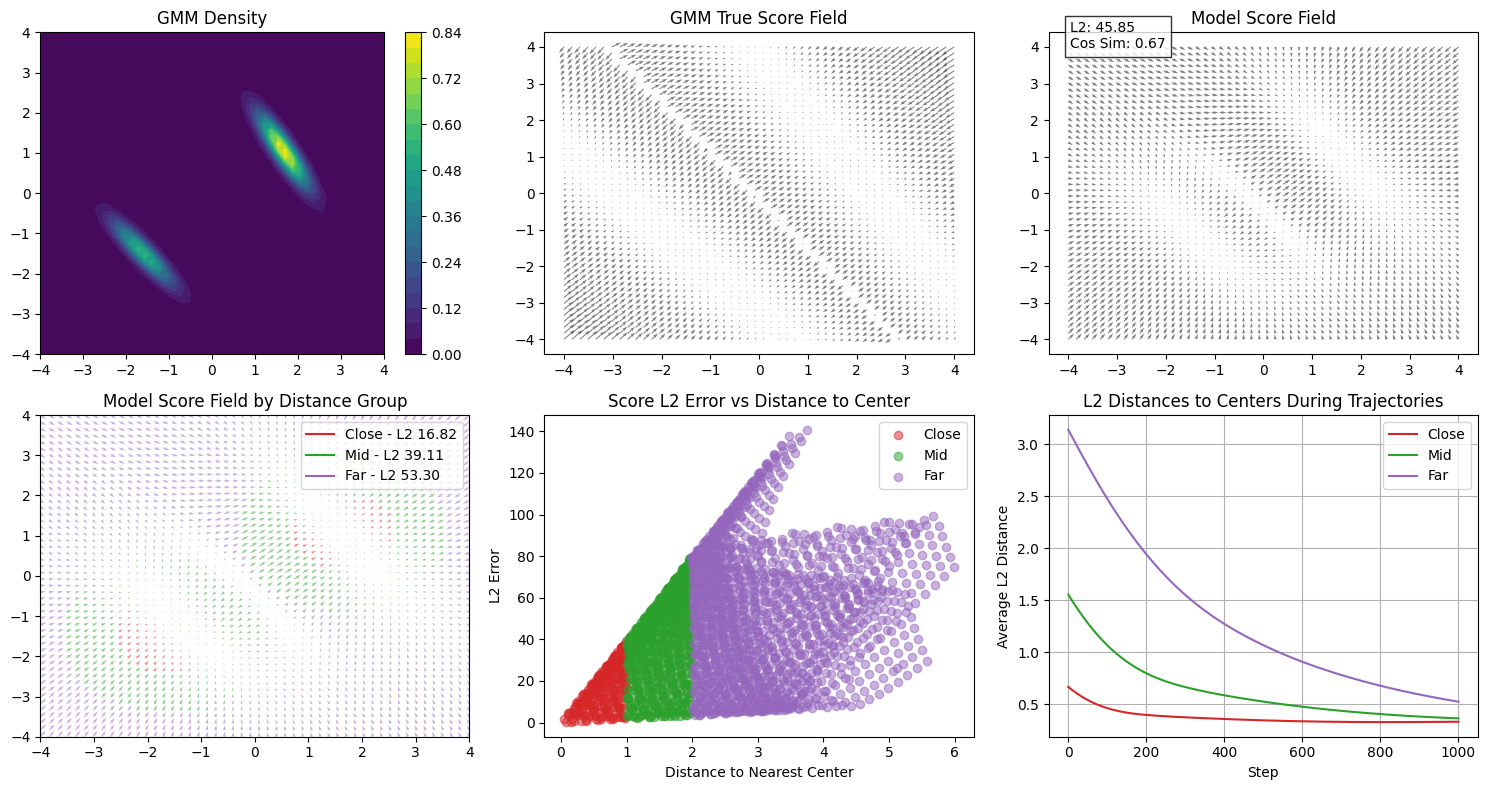

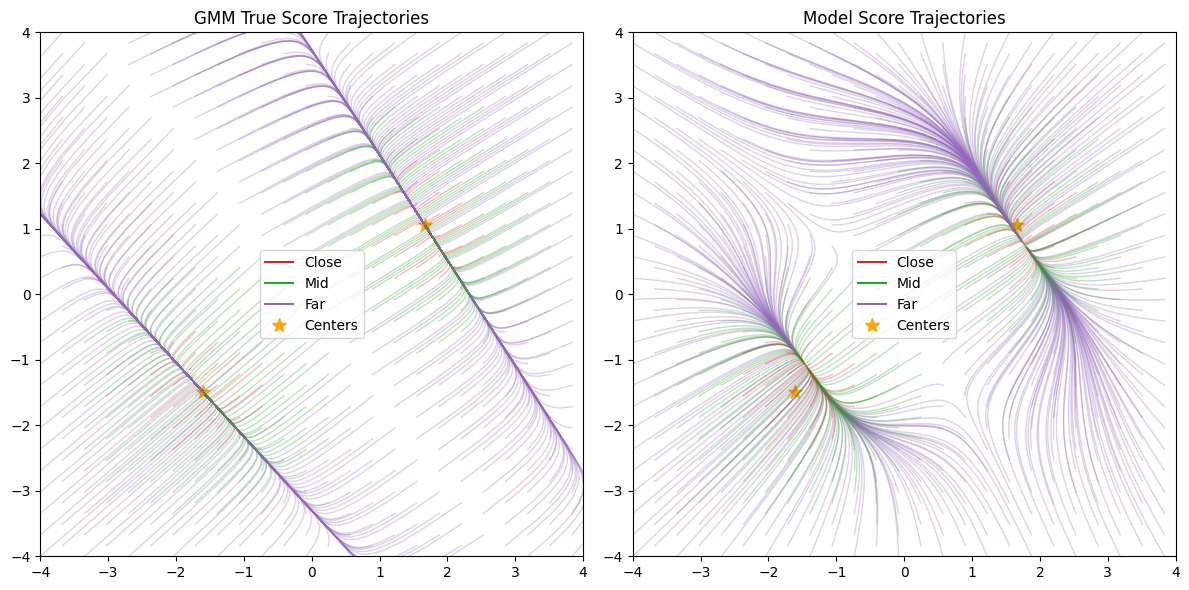

In [33]:
gmm = GaussianMixture(mus, covs, weights)

model = ScoreNetGMM(
    data_dim=2,
    hidden_dims=[128, 256, 512],
    embed_dim=256
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))

score_fig = plot_score_fields(model, gmm, device)
trajectory_fig = plot_trajectories(model, gmm, device)

plt.show()

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mus = gmm_params['2d_spiral_2']['mus']
covs = gmm_params['2d_spiral_2']['covs']
weights = gmm_params['2d_spiral_2']['weights']

mus = [np.array(mu) for mu in mus]
covs = [np.array(cov) for cov in covs]
weights = np.array(weights)
model_path = '/content/drive/MyDrive/UT_Austin/Diffusion_Models_Testing/memorization_generalization_in_diffusion_models/score_models/gmm_score_model/gmm_new_2d/spiral_2/ckpt_10.pth'
#model_noise_type = 'gaussian'

<ipython-input-31-2cb582fb95ec>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


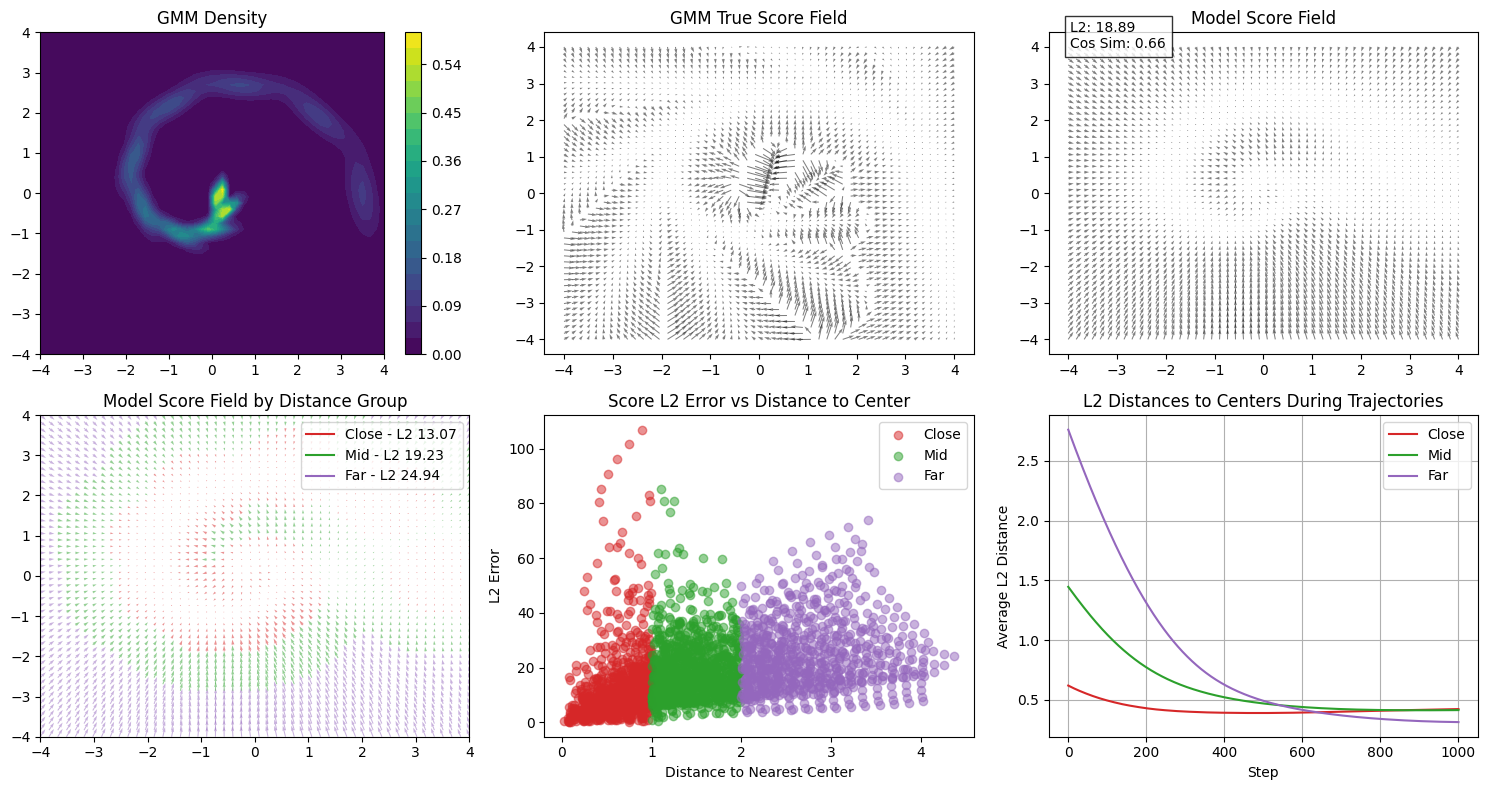

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


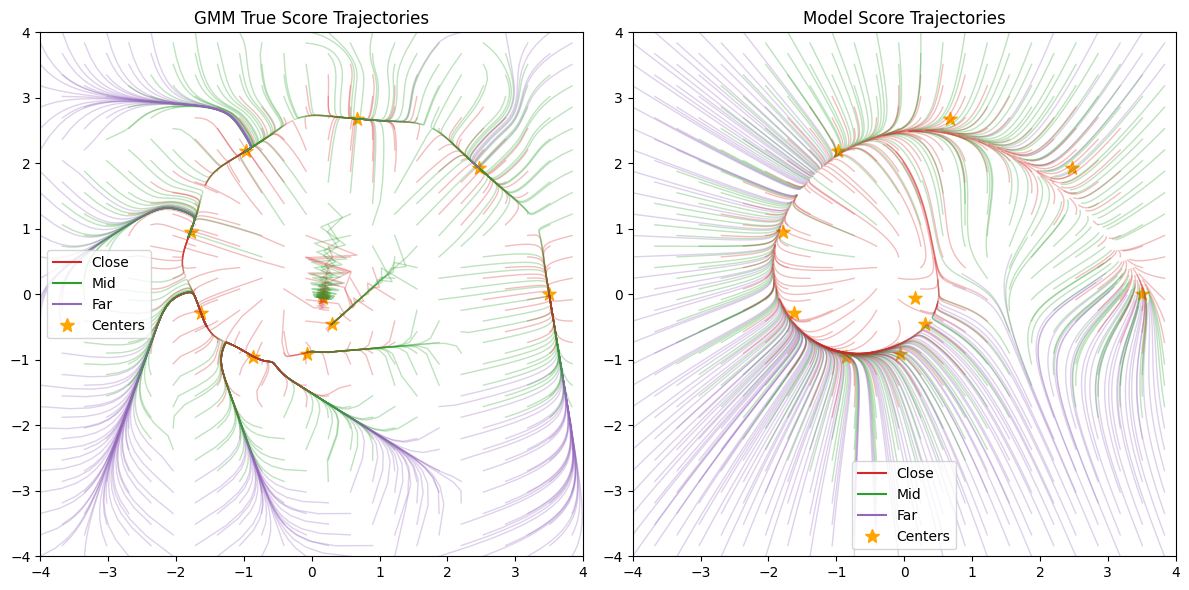

In [31]:
gmm = GaussianMixture(mus, covs, weights)

model = ScoreNetGMM(
    data_dim=2,
    hidden_dims=[128, 256, 512],
    embed_dim=256
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))

score_fig = plot_score_fields(model, gmm, device)
trajectory_fig = plot_trajectories(model, gmm, device)

plt.show()